In [1]:
import nengo
import nengo_spa as spa
import pytry
import numpy as np
from random import shuffle
import random
import sys, os
import math
from IPython import display
from scipy.optimize import brute, minimize
from scipy.stats import sem
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.style as style

import os

from itertools import product



# Import our classes
sys.path.append('..')
import experiments as xps
from experiments import create_xp
from model import ExperimentRun, create_vocab
from data import Data

# Optimization and model parameters

In [2]:
D = int(96)  # the dimensionality of the vectors
PROC_FDBCK = .9
PROC_FDBCK_SYN = .005
GW_FDBCK = 1
GW_SCALE = 20 # scale the input of GW for saturation and catching very short visual stimuli
BG_THR = .1
BG_BIAS = .5
STIM_DURATION = .1
FIX_DURATION = .5
N_NEURONS_SCALE = 1
N_NEURONS_SCALE_COMBINED = .5
INTEGRATOR_RESET = False
N_SAMPLES = 10000

N_BLOCKS_PER_OPERATION = 1 # default: 10
N_TRIALS_PER_DIGIT = 2 # default: 5
N_DIFFERENT_DIGITS = 4 # default: 4
N_DIFFERENT_OPERATIONS = 3 # default: 3

data_dir = "evaluate_fit/fit_no_threshold_save"


[ 5. 10.]
condition  1 / 4 : (0, 0, 0)
	 sensory delay: 0
	 evidence strength: 5.0
	 crosstalk: 0.1
	 Simulating...
	 seed 1/5
	 seed 2/5
	 seed 3/5
	 seed 4/5
	 seed 5/5


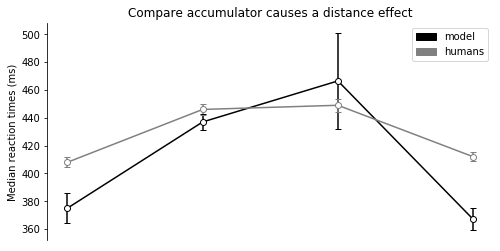

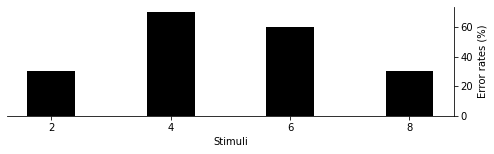

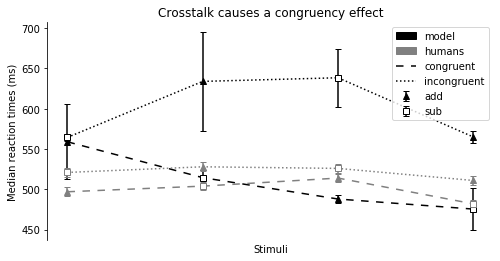

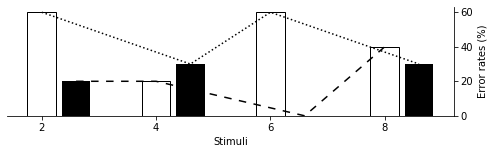

	 rmse: 95.27502433989342
	 error rate: 0.375
condition  5 / 4 : (0, 0, 1)
	 sensory delay: 0
	 evidence strength: 5.0
	 crosstalk: 0.2
	 Simulating...
	 seed 1/5
	 seed 2/5
	 seed 3/5
	 seed 4/5
	 seed 5/5


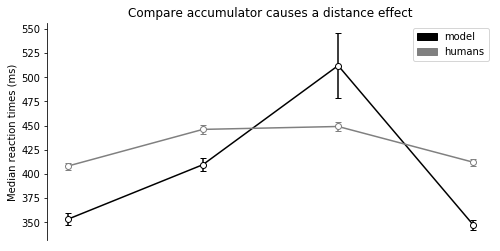

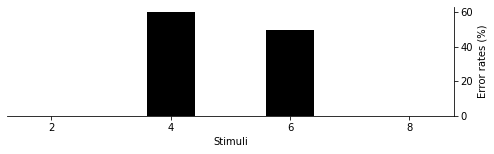

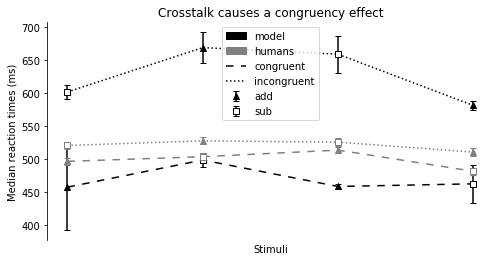

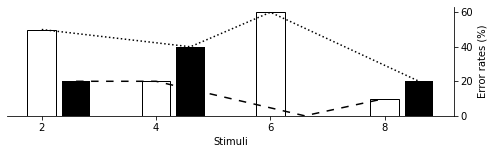

	 rmse: 93.27000405616839
	 error rate: 0.275
condition  5 / 4 : (0, 1, 0)
	 sensory delay: 0
	 evidence strength: 10.0
	 crosstalk: 0.1
	 Simulating...
	 seed 1/5
	 seed 2/5
	 seed 3/5
	 seed 4/5
	 seed 5/5


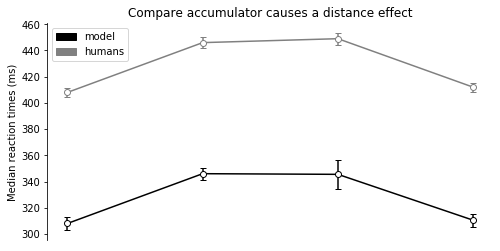

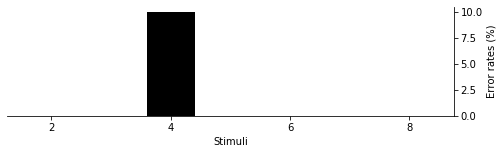

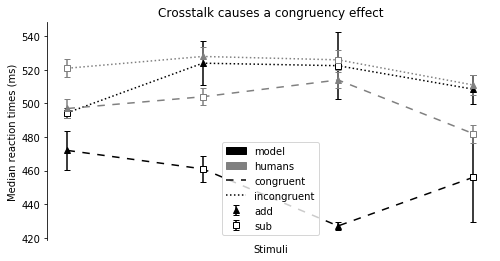

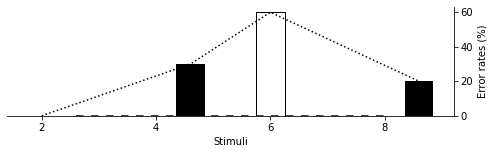

	 rmse: 90.06485812082123
	 error rate: 0.09999999999999998
condition  5 / 4 : (0, 1, 1)
	 sensory delay: 0
	 evidence strength: 10.0
	 crosstalk: 0.2
	 Simulating...
	 seed 1/5
	 seed 2/5
	 seed 3/5
	 seed 4/5
	 seed 5/5


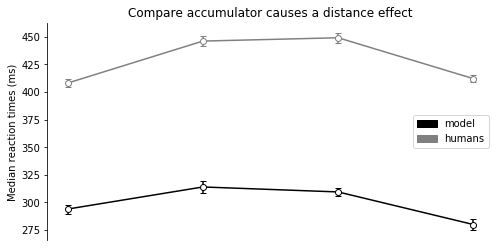

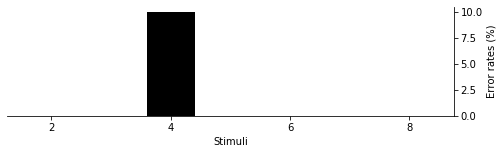

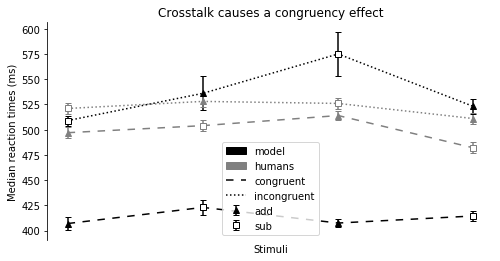

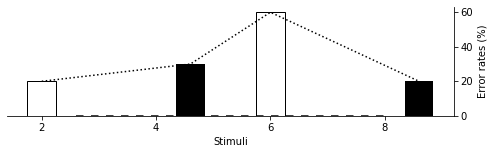

	 rmse: 115.91652741175821
	 error rate: 0.1166666666666667


In [3]:
STARTING_SEED = 1
N_SEEDS = 5

t_sensos = [0]#np.linspace(.05, .2, 5)
s_evids = np.linspace(5, 10, 2)
crosstalks = np.linspace(.1, .2, 2)
print(s_evids)

rmses = np.zeros((len(t_sensos), len(s_evids), len(crosstalks)))

i=0
for condition in product(*tuple([range(len(param_values)) for param_values in [t_sensos, s_evids, crosstalks]])):
    i+=1
    print('condition ', i, '/', rmses.size, ':', condition)  
    print('\t sensory delay:', t_sensos[condition[0]]*1000)
    print('\t evidence strength:', s_evids[condition[1]])
    print('\t crosstalk:', crosstalks[condition[2]])
    data = []

#     return 0

    print('\t Simulating...')
    for i,seed in enumerate(range(STARTING_SEED, STARTING_SEED+N_SEEDS)):
        print('\t seed '+str(i+1)+'/'+str(N_SEEDS))
        data_filename = 'run_seed'+str(seed)+'_sevid'+str(s_evids[condition[1]])+'_crosstalk'+str(crosstalks[condition[2]])         

        try:
            seed_data = pd.read_pickle(data_dir+'/'+data_filename+'.csv')

        except FileNotFoundError:
            xp = create_xp(N_BLOCKS_PER_OPERATION, N_TRIALS_PER_DIGIT, N_DIFFERENT_DIGITS, N_DIFFERENT_OPERATIONS, STIM_DURATION, FIX_DURATION, seed)
            results = ExperimentRun().run(
                n_neurons_scale=N_NEURONS_SCALE,
                n_neurons_scale_combined=N_NEURONS_SCALE_COMBINED,
                s_evidence=s_evids[condition[1]],
                s_crosstalk=crosstalks[condition[2]],
                n_samples=N_SAMPLES,
                vocab=create_vocab(D, seed),
                xp=xp,
                integrator_reset=True,
                proc_feedback=PROC_FDBCK,
                proc_feedback_synapse=PROC_FDBCK_SYN,
                GW_feedback=GW_FDBCK,
                GW_scale=GW_SCALE,
                BG_thr=BG_THR,
                BG_bias=BG_BIAS,
                seed=seed,
                backend="nengo_ocl",
                data_dir=data_dir,
                data_filename=data_filename,
                plt=False
            )
            seed_data = results['data'].df
            seed_data.to_pickle(data_dir+'/'+data_filename+'.csv')

        data.append(seed_data)


    data = Data(pd.concat(data))
    data.df['rt'] += t_sensos[condition[0]]*1000 # add sensory delay to reaction times

    data.plot_fig2_simple(plot_humans=True)
    data.plot_fig2_chained(plot_humans=True)
    rmse_fitness_error = data.rmse_fitness_error(compare_errorrates=False, compare_RTs=True, tasks=range(N_DIFFERENT_OPERATIONS))
    print('\t rmse:', rmse_fitness_error[0])
    print('\t error rate:', data.error_rate)
    
    rmses[condition] = rmse_fitness_error[0]





In [9]:
np.linspace(.05, .2, 10)

array([0.05      , 0.06666667, 0.08333333, 0.1       , 0.11666667,
       0.13333333, 0.15      , 0.16666667, 0.18333333, 0.2       ])